In [1]:
import numpy as np
import GCRCatalogs
import pyccl as ccl
import time
import matplotlib.pyplot as plt
from scipy import special
from scipy import integrate
%matplotlib inline

gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

cosmo = ccl.Cosmology(Omega_c=gc.cosmology.Om0-gc.cosmology.Ob0,
                      Omega_b=gc.cosmology.Ob0, h=gc.cosmology.h,
                      sigma8=gc.cosmology.sigma8,
                      n_s=gc.cosmology.n_s) 

M_bias = 1
sigma_lnM = 0.25
G = 4.79*1e-20  
h = gc.cosmology.h
H0 = h/3e3
Omega_m0 = gc.cosmology.Om0

def hubble(z):
    return ccl.h_over_h0(cosmo,1/(1+z))

def rho_cr(z):
    return ccl.background.rho_x(cosmo,1/(1+z),'critical', is_comoving=False)

def delta_c(c):
    return 200.0*c**3/( 3.0*(np.log(1+c)-c/(1.0+c)) )

def gammaa0(x):
    if x<1:
        g = 8*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/(x**2*np.sqrt(1.0-x**2))  +  4*np.log(x/2.0)/x**2  -  2.0/(x**2-1.0)  +   4*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/((x**2-1.0)*np.sqrt(1.0-x**2))######
    elif x==1:
        g = 10.0/3.0 +4*np.log(1.0/2.0)
    else:
        g = 8*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/(x**2*np.sqrt(x**2-1.0))  +  4*np.log(x/2.0)/x**2  -  2.0/(x**2-1.0)  +   4*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/pow(x**2-1.0,1.5)######
    return g

def Sigma_nfw0(x):
    if x<1:
        y = (  1-2*np.arctanh(np.sqrt((1.0-x)/(1.0+x)))/np.sqrt(1.0-pow(x,2))  )/(pow(x,2)-1.0)
    elif x==1:
        y = 1.0/3.0
    else:
        y = (  1-2*np.arctan(np.sqrt((x-1.0)/(1.0+x)))/np.sqrt(pow(x,2)-1.0)  )/(pow(x,2)-1.0)
    return y

def mean_Sigma_sat(R,D,M_sat):
    def integrand(R_prime):
        return R_prime*Sigma_sat(R_prime,D,M_sat)
    result = integrate.quad(integrand, 0, R)[0]
    return 2.0*result/R**2

def mean_Sigma_log(R,D,M_sat):
    def integrand(R_prime):
        return R_prime*np.array(list(map(Sigma_sat,R_prime,[D]*len(R_prime),[M_sat]*len(R_prime))))
    N = 100
    logx0 = np.logspace(-2,np.log10(R),N)
    y0 = integrand(np.sqrt(logx0[1:]*logx0[:-1]))
    result = np.sum(y0*(logx0[1:]-logx0[:-1]))
    return 2.0*result/R**2    

In [2]:
M_cent = 1e14 #Msun/h
c = 5 
R_perp = np.logspace(-2, 2, 50) #Mpc/h comoving
once = True


def R_S(M_200,c):
    r200 = pow(3*M_200/(800*np.pi*rho_cr(z_L)),1.0/3.0)
    return r200/c

def gammaa(x):
    y = np.zeros_like(x)
    mask1 = x<1
    x1 = x[mask1]
    mask2 = x==1
    mask3 = x>1
    x3 = x[mask3]
    y[mask1] = 8*np.arctanh(np.sqrt((1.0-x1)/(1.0+x1)))/(x1**2*np.sqrt(1.0-x1**2))  +  4*np.log(x1/2.0)/x1**2  -  2.0/(x1**2-1.0)  +   4*np.arctanh(np.sqrt((1.0-x1)/(1.0+x1)))/((x1**2-1.0)*np.sqrt(1.0-x1**2))######
    y[mask2] = 10.0/3.0 +4*np.log(1.0/2.0)
    y[mask3] = 8*np.arctan(np.sqrt((x3-1.0)/(1.0+x3)))/(x3**2*np.sqrt(x3**2-1.0))  +  4*np.log(x3/2.0)/x3**2  -  2.0/(x3**2-1.0)  +   4*np.arctan(np.sqrt((x3-1.0)/(1.0+x3)))/pow(x3**2-1.0,1.5)######
    return y


def Sigma_nfw(x):
    y = np.zeros(x.shape)
    mask1 = x<1
    x1 = x[mask1]
    mask2 = x==1
    mask3 = x>1
    x3 = x[mask3]
    y[mask1] = (  1-2*np.arctanh(np.sqrt((1.0-x1)/(1.0+x1)))/np.sqrt(1.0-pow(x1,2))  )/(pow(x1,2)-1.0)
    y[mask2] = 1.0/3.0
    y[mask3] = (  1-2*np.arctan(np.sqrt((x3-1.0)/(1.0+x3)))/np.sqrt(pow(x3,2)-1.0)  )/(pow(x3,2)-1.0)
    return 2*y


def Sigma_sat(R,D,M_sat):
    def integrand(theta):
        R_equi = np.sqrt(R**2+D**2-2*R*D*np.cos(theta))
        x1 = R_equi/r_s
        x1[x1==0] = 1e-3
        return Sigma_nfw(x1)

    N = 100
    if type(R)==float or type(R)==int:
        R = np.array([R])
        
    theta_x = np.linspace(0,2*np.pi,N)
    theta_x = np.broadcast_to(theta_x,(len(R),N))  #shape: (len(R_perp),N)
    R = np.broadcast_to(R,(N,len(R))).transpose()  #shape: (len(R_perp),N)
    r_s = R_S(M_sat,c)
    y_unit = r_s*delta_c(c)*rho_cr(z_L)
    fx = integrand(theta_x)
    result = np.trapz(fx,theta_x)*y_unit
    #result = integrate.quad(integrand, 0, 2*np.pi)[0]*y_unit
    return result/(2*np.pi)


def mean_Sigma_trpz(R,D,M_sat):
    def integrand(R_prime):
        return R_prime*Sigma_sat(R_prime,D,M_sat)
    N = 250
    x0 = np.logspace(-5,np.log10(R),N).transpose()   #x0 shape: (len(R_perp),N)
    result = np.zeros(len(R))
    for i in range(len(R)):
        x1 = x0[i]
        y0 = integrand(x1)
        result[i] = np.trapz(y0,x1)
    return 2.0*result/R**2

def shear(M_200,c):
    r_s = R_S(M_200,c)
    y_unit = r_s*delta_c(c)*rho_cr(z_L)
    xx = R_perp/r_s
    delta_sigma = gammaa(xx)*y_unit
    return delta_sigma/Sigma_cr

def shear_sat(D,M_sat):
    sr = Sigma_sat(R_perp,D,M_sat)
    s_mean = mean_Sigma_trpz(R_perp,D,M_sat)
    return (s_mean-sr)/Sigma_cr

In [3]:
z_L = 0.3
D_L = ccl.comoving_radial_distance(cosmo, 1/(1+z_L))/(1+z_L)
z_S = 1.0
D_S = ccl.comoving_radial_distance(cosmo, 1/(1+z_S))/(1+z_S)
D_SL = (ccl.comoving_radial_distance(cosmo, 1/(1+z_S)) - ccl.comoving_radial_distance(cosmo, 1/(1+z_L)))/(1+z_S)
Sigma_cr = D_S / (4 * np.pi * G * D_SL * D_L)

In [4]:
#R_perp = np.logspace(-2, 2, 50) #Mpc/h comoving
distances = np.logspace(-2,1,50)
#distances = np.linspace(1e-2,10,100)
M_cen = 1e14 #Msun/h
M_sat = 1e12 #Msun/h
ntotal = 1000

def GNFW(M_cen,r,beta):
    r_s = R_S(M_cen,c)
    x = r/r_s
    return 1/(pow(x,beta)*pow(1+x,3-beta))

def Sigma_GNFW(M_cen,r,beta):
    def integrand_GNFW(phi,x,beta):
        u1 = pow(1+phi**2,0.5)
        return 2*pow(u1,-beta)*pow(1+x*u1,beta-3)

    N = 100
    r_s = R_S(M_cen,c)
    x = r/r_s
    phi1 = np.linspace(0,1000,N)
    sigma_GNFW = np.zeros(len(x))
    for i in range(len(x)):
        y_GNFW = integrand_GNFW(phi1,x[i],beta)
        sigma_GNFW[i] = np.trapz(y_GNFW,phi1)
    
    return r*pow(x,-beta)*sigma_GNFW

def cen_distri(beta,M_cen, M_sat):
    prob = np.zeros(len(distances)-1)
    p0 = Sigma_GNFW(M_cen,distances,beta)*distances
    normfac = np.trapz(p0,distances)
    for i in range(len(prob)):
        prob[i] = np.trapz(p0[i:i+2],distances[i:i+2])/normfac

    gamma_sat = np.zeros((len(distances),len(R_perp)))
    total_gamma = np.zeros(len(R_perp))
    for i in range(len(prob)):
        D = np.sqrt(distances[i]*distances[i+1])
        gamma_sat[i] = shear_sat(D,M_cen)
        total_gamma = total_gamma + gamma_sat[i]*prob[i]
    return total_gamma

    
def sat_gamma(beta,M_cen, M_sat,ntotal):
    return shear(M_sat,5)+ cen_distri(beta,M_cen,M_sat,ntotal)

t1 = time.time()
g_tot20 = cen_distri(2,M_cen,M_sat)
g_tot10 = cen_distri(1,M_cen,M_sat)


t2 = time.time()
print(t2-t1)
g_tot5 = cen_distri(.5,M_cen,M_sat)
t3 = time.time()
print(t3-t2)
#g_tot3 = cen_distri(.3,M_cen,M_sat,ntotal)/ntotal
t4 = time.time()
print(t4-t3)

11.024376392364502
5.2393693923950195
0.00018358230590820312


In [5]:
R_perp = np.array([0.03300041, 0.03957563, 0.04739823, 0.05675097, 0.06796628,
        0.08139344, 0.09744405, 0.11666072, 0.13971456, 0.1673012 ,
        0.20036395, 0.23988418, 0.28719691, 0.34383813, 0.41164832,
        0.49288679, 0.59015923, 0.70658378, 0.84581007, 1.0125192 ])
data1 = np.array([0.0048955 , 0.0049727 , 0.0044159 , 0.00379086, 0.00347952,
        0.00325853, 0.00260748, 0.00216641, 0.00173661, 0.00137027,
        0.00099873, 0.00080666, 0.00064047, 0.000531  , 0.0004815 ,
        0.00036901, 0.00040512, 0.00024013, 0.00014383, 0.00012095])
sqrtvar = np.array([0.00022717, 0.00027646, 0.0002524 , 0.0002592 , 0.00029377,
        0.00033411, 0.00025817, 0.00020466, 0.00016643, 0.00013755,
        0.0001021 , 0.00012293, 0.00012086, 0.00014783, 0.00015087,
        0.00016262, 0.00015448, 0.00012752, 0.00017307, 0.00020435])

In [15]:
import emcee 

cov = np.diag(sqrtvar**2)
icov = np.linalg.inv(cov)

def lnprob(theta):
    for i in range(len(theta)):
        Mcen = pow(10,theta[0])
        Msat = pow(10,theta[1])
        beta = theta[2]
        #beta = 1.0
        if (Mcen>1e11) & (Mcen<1e15) & (beta>0) & (beta<3) & (Msat>1e10) & (Msat<Mcen):
            model = cen_distri(beta,Mcen,Msat)+shear(Msat,5)
            diff = data1-model
            return -np.dot(diff,np.dot(icov,diff))/2.0
        else:
            return -np.inf


In [16]:
dim = 3
nwalkers = 100

p0 = np.zeros((nwalkers,dim))

p0[:,0] = [np.array([13])*np.ones(1)+np.array([2]) * np.random.rand() for i in range(nwalkers)] 
p0[:,1] = [np.array([12])*np.ones(1)+np.array([1]) * np.random.rand() for i in range(nwalkers)] 
p0[:,2] = [np.array([1])*np.ones(1)+np.array([0.8]) * np.random.rand() for i in range(nwalkers)] 


p0 = np.array(p0)
p0 = p0 - len(p0)*[[1,0.5,0.4]]


#plt.plot(p0[:,0],p0[:,1])

In [ ]:
from multiprocessing import Pool

nsteps = 60

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, dim, lnprob, pool=pool)
    t1 = time.time()
    pos, prob, state = sampler.run_mcmc(p0, nsteps, progress=True)
    t2 = time.time()
    print(t2-t1)
    
    sampler.reset()
    t1 = time.time()
    sampler.run_mcmc(pos, nsteps, rstate0=state);
    t2 = time.time()
    print(t2-t1)

  0%|          | 0/60 [00:00<?, ?it/s]

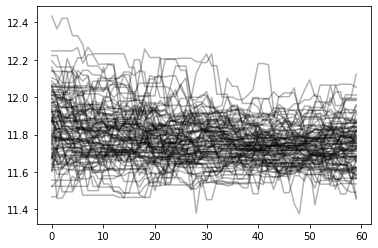

In [9]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)

Mean acceptance fraction: 0.5914999999999999


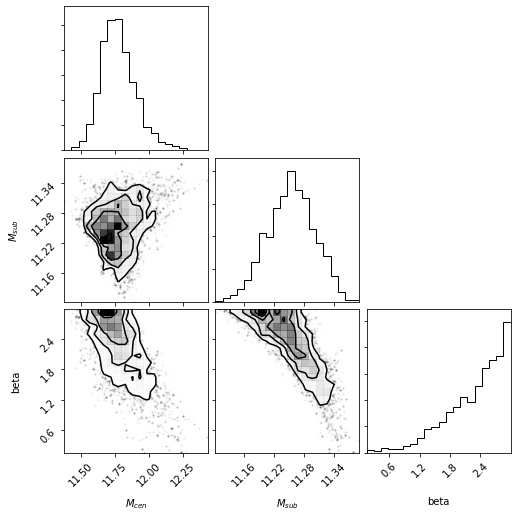

In [10]:
import corner
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
samples = sampler.chain[:, :, :].reshape((-1, dim))
figure = corner.corner(samples,labels=[r"$M_{cen}$",r"$M_{sub}$", 'beta'])


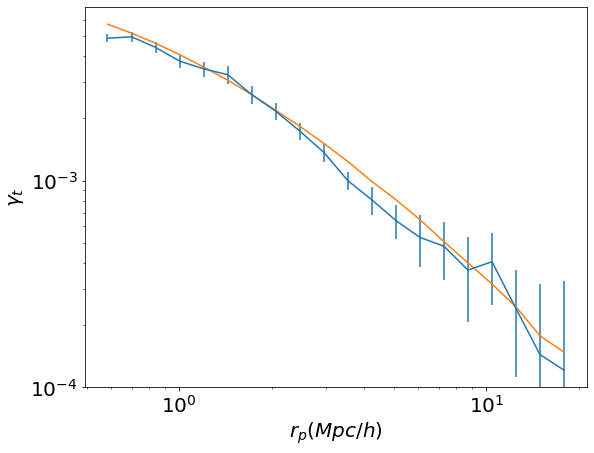

In [14]:
plt.figure(figsize=[9,7])

plt.errorbar(R_perp*ccl.comoving_radial_distance(cosmo, 1/(1+0.35))*np.pi/(180*(1+0.35)), data1, sqrtvar, label='$all$')
plt.plot(R_perp*ccl.comoving_radial_distance(cosmo, 1/(1+0.35))*np.pi/(180*(1+0.35)),cen_distri(3,pow(10,11.75),pow(10,11.25))+shear(pow(10,11.25),5))
#plt.legend()

plt.plot(0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p(Mpc/h)$',fontsize=20)
plt.ylabel('$\gamma_t$',fontsize=20)
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Mean acceptance fraction: 0.6027999999999999


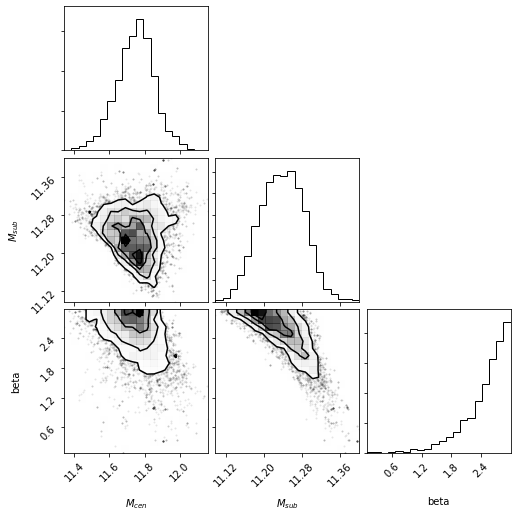

In [16]:
import corner
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
samples = sampler.chain[:, :, :].reshape((-1, dim))
figure = corner.corner(samples,labels=[r"$M_{cen}$",r"$M_{sub}$", 'beta'])


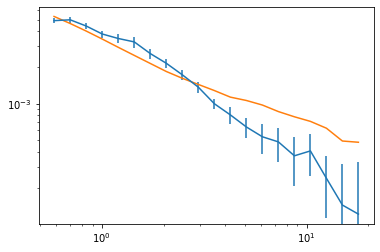

In [20]:
plt.figure(figsize=[9,7])

plt.errorbar(R_perp*ccl.comoving_radial_distance(cosmo, 1/(1+0.35))*np.pi/(180*(1+0.35)), data1, sqrtvar, label='$all$')
plt.plot(R_perp*ccl.comoving_radial_distance(cosmo, 1/(1+0.35))*np.pi/(180*(1+0.35)),cen_distri(0.5,8e12,2e11)+shear(2e11,5))
#plt.legend()

plt.plot(0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p(Mpc/h)$',fontsize=20)
plt.ylabel('$\gamma_t$',fontsize=20)
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


Mean acceptance fraction: 0.5728


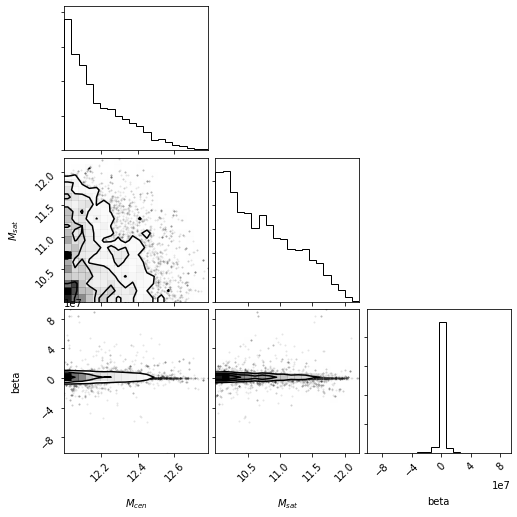

In [13]:
import corner
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
samples = sampler.chain[:, :, :].reshape((-1, dim))
figure = corner.corner(samples,labels=[r"$M_{cen}$",r"$M_{sat}$", 'beta'])
